In [9]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from qiskit import IBMQ, Aer, BasicAer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import state_fidelity
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library.generalized_gates.mcmt import MCMT
from qiskit.circuit.library.standard_gates.x import XGate, HGate
from qiskit.circuit.library import ZGate
from qiskit.visualization import plot_histogram

/home/kinga/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


In [48]:
def AndOracle(nn):
    
    ''' and-oracle: checks if all input register qubits are |1>
        adapted from: github.com/jianzhi-1/qiskit_advo
    '''
    
    circuit = QuantumCircuit(nn+1) # digit encoded in nn qubits + 1 ancilla qubit + 1 measurement bit
    
    circuit.barrier()    
    # multi control x gate on encoded int with ancilla target
    circuit.mcx(list(range(nn)), nn)
    circuit.barrier()
    
    return circuit

In [77]:
def ControlledOnIntOracle(nn, x):
    
    ''' controlled on int oracle: checks if quantum state (register) represents binary encoded integer x
        adapted from: github.com/jianzhi-1/qiskit_advo
        :param nn ... size of quantum register to encode integer
    '''
    
    if (x != 0 and nn < int(math.floor(math.log2(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    
    circuit = QuantumCircuit(nn+1) ## nn qubits for integer encoding + 1 ancilla
    
    circuit.barrier()
    
    # get binary representation
    xx = [int(x) for x in list('{0:0{width}b}'.format(x, width=nn))]

    # flip all binary zeroes in encoded integer
    for n, b in enumerate(xx):
        if b == 0:
            circuit.x(n)
            
    # apply and-oracle
    and_oracle = AndOracle(nn)
    circuit.append(and_oracle, list(range(nn+1)))
    
    # flip all binary ones back
    for n, b in enumerate(xx):
        if b == 0:
            circuit.x(n)
    
    circuit.barrier()
    
    return circuit

# test and-oracle

## build oracle

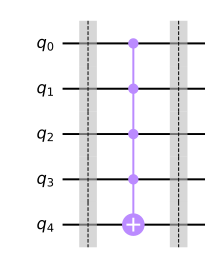

In [49]:
nn = 4 # number of qubits to encode int
and_oracle = AndOracle(nn)
and_oracle.draw(output='mpl')

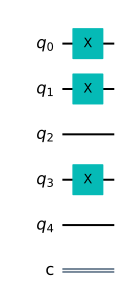

In [58]:
and_test = QuantumCircuit(nn+1,1)
for i in [0,1,3]:
    and_test.x(i)
and_test.draw(output='mpl')

In [59]:
and_test.append(and_oracle, list(range(nn+1)))
and_test.measure(nn,0)

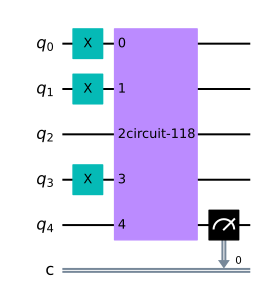

In [60]:
and_test.draw(output='mpl')

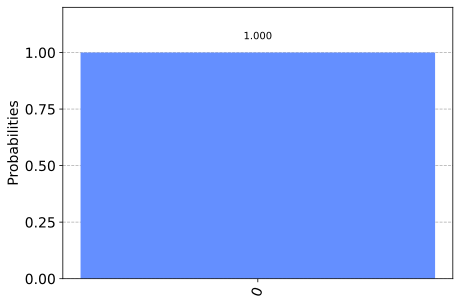

In [61]:
# outputs 1 iff all of the nn qubits are 1, outputs 0 otherwise
simulator = Aer.get_backend('qasm_simulator')
counts = execute(and_test, backend=simulator, shots=1000).result().get_counts(and_test)
plot_histogram(counts)

# test controlled-on-int-oracle

## matching input

In [78]:
control_integer = 5
nn = int(math.floor(math.log2(control_integer) + 1))
control_integer_bin = [int(x) for x in list('{0:0{width}b}'.format(control_integer, width=nn))]

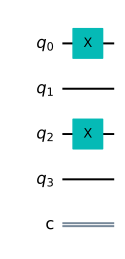

In [79]:
cont_int_test = QuantumCircuit(nn+1, 1) # nn encoding qubits + 1 ancilla + one measurement
# prepare input
for i, v in enumerate(control_integer_bin):
    if v == 1:
        cont_int_test.x(i)
cont_int_test.draw('mpl')

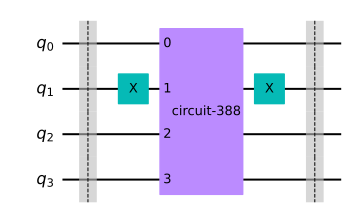

In [80]:
oracle = ControlledOnIntOracle(nn, control_integer)
oracle.draw('mpl')

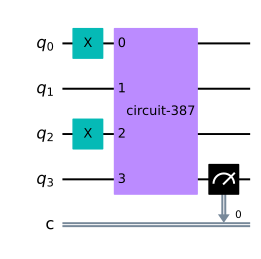

In [81]:
cont_int_test.append(oracle, list(range(nn+1)))
cont_int_test.measure(nn,0)
cont_int_test.draw('mpl')

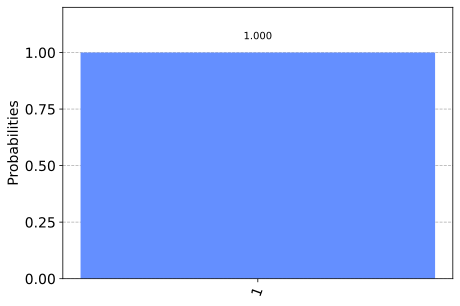

In [82]:
# outputs 1 iff the input is equal to the control integer of the oracle
simulator = Aer.get_backend('qasm_simulator')
counts = execute(cont_int_test, backend=simulator, shots=1000).result().get_counts(cont_int_test)
plot_histogram(counts)

## input not matching oracle

In [87]:
integer = 4
integer_bin = [int(x) for x in list('{0:0{width}b}'.format(integer, width=nn))]

In [88]:
integer_bin

[1, 0, 0]

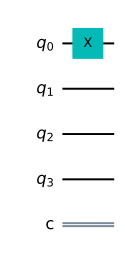

In [85]:
cont_int_test = QuantumCircuit(nn+1, 1) # nn encoding qubits + 1 ancilla + one measurement
# prepare input
for i, v in enumerate(integer_bin):
    if v == 1:
        cont_int_test.x(i)
cont_int_test.draw('mpl')

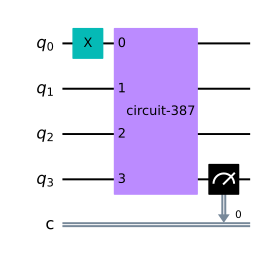

In [89]:
# append oracle constructed to identify value '5'
cont_int_test.append(oracle, list(range(nn+1)))
cont_int_test.measure(nn,0)
cont_int_test.draw('mpl')

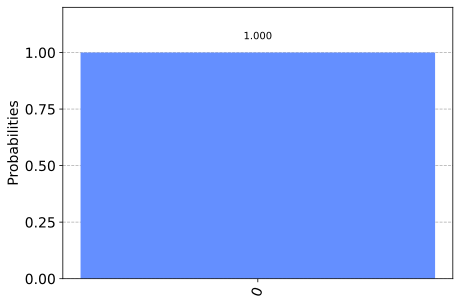

In [90]:
# outputs 1 iff the input is equal to the control integer of the oracle
simulator = Aer.get_backend('qasm_simulator')
counts = execute(cont_int_test, backend=simulator, shots=1000).result().get_counts(cont_int_test)
plot_histogram(counts)

# Linear Composition of winner oracles

In [3]:
cluster_n = 2 # number of clusters determines size of oracles

In [ ]:
def create_threshold_oracle_operator(nn, idcs_to_mark):
    
    # create the identity matrix on n qubits
    oracle_matrix = np.identity(2**nn)
    # add the -1 phase to marked elements
    for idx in idcs_to_mark:
        oracle_matrix[idx, idx] = -1
        
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    return Operator(oracle_matrix)

In [33]:
def get_indices_to_mark(dist_arr, threshold):
    idx, = np.nonzero(dist_arr > threshold)
    return idx

In [4]:
def create_threshold_oracle_lincombi(dist_arr, threshold):
    
    ''' 
    create linear combination of oracles sum(oracle_t)
    where oracle_t marks all indices i for which f(i) < threshold t
    '''
    
    cluster_n = len(dist_arr)
    nn = int(math.floor(math.log2(cluster_n) + 1))
    oracles = []
    
    
    for threshold in dist_arr:
        idcs_to_mark = get_indices_to_mark(dist_arr, threshold) # what for empty set (min ele)?
        oracles.append(create_threshold_oracle_operator(cluster_n, idcs_to_mark))
        
    oracle_sum = 0.
    for oracle in oracles:
        oracle_sum += a * oracle
    
     # create a quantum circuit on nn qubits
    qc = QuantumCircuit(nn, name='combi_oracle')
        
    # convert oracle_matrix into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_sum), range(nn))
    
    return qc

In [10]:
arr = np.array([2,5,4,6,17,1])

In [31]:
idx, = np.nonzero(arr > 4)

In [32]:
idx

array([1, 3, 4])

In [25]:
len(idx)

1